[<img src="https://www.arcosdorados.com/wp-content/uploads/2019/05/ArcosDoradosLogoX.png" width="300" height="150" align='right'>](http://digitalhouse.com.ar/)

In [1]:
# Importo las librerias que voy a utilizar.
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression

/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Importo el dataset provisto relacinado con compras en amazon.
df = pd.read_csv('amazon_reviews_us_Luggage_v1_00.tsv',sep='\t',error_bad_lines=False)

b'Skipping line 21775: expected 15 fields, saw 22\nSkipping line 35823: expected 15 fields, saw 22\nSkipping line 46386: expected 15 fields, saw 22\n'
b'Skipping line 75998: expected 15 fields, saw 22\nSkipping line 82507: expected 15 fields, saw 22\nSkipping line 98223: expected 15 fields, saw 22\nSkipping line 129152: expected 15 fields, saw 22\nSkipping line 130115: expected 15 fields, saw 22\n'
b'Skipping line 131270: expected 15 fields, saw 22\nSkipping line 151687: expected 15 fields, saw 22\n'
b'Skipping line 196882: expected 15 fields, saw 22\nSkipping line 213341: expected 15 fields, saw 22\nSkipping line 233947: expected 15 fields, saw 22\n'


In [3]:
# shape del dataset.
df.shape

(348461, 15)

In [4]:
# Tipos de las columnas.
df.dtypes

marketplace           object
customer_id            int64
review_id             object
product_id            object
product_parent         int64
product_title         object
product_category      object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                  object
verified_purchase     object
review_headline       object
review_body           object
review_date           object
dtype: object

In [5]:
# Genero una serie de la distribucion de estrellas.
barData = df.star_rating.value_counts(normalize=True)*100

In [6]:
barData


5.0    62.095793
4.0    17.617804
3.0     7.987430
1.0     7.174138
2.0     5.124835
Name: star_rating, dtype: float64

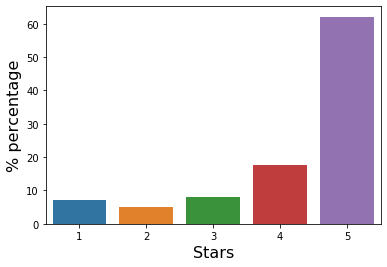

In [7]:
# Hago el grafico de barras por estrella.
plt.Figure()
sns.barplot(x=[ int(i) for i in barData.index],y=barData);
plt.xlabel('Stars', fontsize=16)
plt.ylabel('% percentage', fontsize=16)
plt.savefig('stars_dist.png')

In [8]:
# Frecuencia acumumulada de estrellas.
barData[barData.index < 3].sum(),barData[barData.index > 3].sum()

(12.298972622395684, 79.71359696952304)

**Conclusiones:** Tengo sobre representado mucha gente con 3-5 estrellas (79 %) y del 12 % restante tiene muy malas reseñas.

## Clasificador y sentiment analysis.

La idea es generar un clasificador de reseñas que devuelva la puntuacion de la misma en funcion del texto.

In [9]:
# Saco todas las reseñas vacias y genero un dataset donde tengo el body de cada una de ellas.
df_txt = df.dropna(subset=['review_body'])
df_txt['sentiment'] = df.star_rating.apply(lambda x: 0 if x<3 else 1)

/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Defino mi stopwords
my_words = ['br']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)

In [11]:
# Genero una funcion que devuelve una modelo logistico.
def train_model(X_train, X_test, y_train, y_test):
    '''Entrena un modelo bayesiano multinomial'''
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    # Instancio modelo multinomial
    lr = LogisticRegression()
    # Fiteo el modelo.
    lr.fit(X_train, y_train)
    # hago la prediccion.
    labels_predichas = lr.predict(X_test)
    # Calculo el accuracy del mismo.
    print(accuracy_score(y_test, labels_predichas))
    mat = confusion_matrix(y_test, labels_predichas)
    print(mat.shape)
    ax=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(set(y_train)), yticklabels=list(set(y_train)))
    plt.xlabel('True Stars')
    plt.ylabel('Predicted Stars')
    cr = classification_report(y_test, labels_predichas)
    return cr


In [12]:
# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(df_txt['review_body'], df_txt['star_rating'], test_size=0.2, random_state=42)

In [13]:
#Primera aproximacion con countVectorizer
# Pongo stopWords en ingles.
modelo_cvec = CountVectorizer(stop_words='english')
# Fiteo sobre el X_train
X_train = modelo_cvec.fit_transform(X_train)
# Transformo sobre el test.
X_test = modelo_cvec.transform(X_test)
# 57251 palabras distintas. matrix muy sparsa.
print(X_train.shape,X_test.shape)

(278751, 62189) (69688, 62189)


/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6982981288026633
(5, 5)


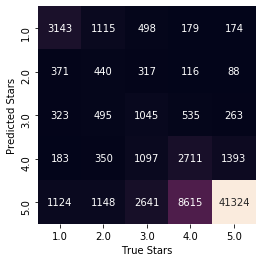

In [14]:
results_countv= train_model(X_train, X_test, y_train, y_test)

In [15]:
print(results_countv)

              precision    recall  f1-score   support

         1.0       0.62      0.61      0.61      5144
         2.0       0.33      0.12      0.18      3548
         3.0       0.39      0.19      0.25      5598
         4.0       0.47      0.22      0.30     12156
         5.0       0.75      0.96      0.84     43242

    accuracy                           0.70     69688
   macro avg       0.51      0.42      0.44     69688
weighted avg       0.64      0.70      0.65     69688



## TF-IDF Vectorizer.

In [16]:
# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(df_txt['review_body'], df_txt['star_rating'], test_size=0.2, random_state=42)
# Opero esta vez con el tfidf vectorizer.
tdfidf = TfidfVectorizer(ngram_range = ((2,2)), stop_words=set(my_stop_words),min_df=0.01,max_df=0.98)
# hago el fit 
X_train = tdfidf.fit_transform(X_train)
# transformo el test
X_test= tdfidf.transform(X_test)
# Miro el shape de cada dataset.
print(X_train.shape,X_test.shape)

(278751, 20) (69688, 20)


/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6205085524050051
(5, 5)


/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


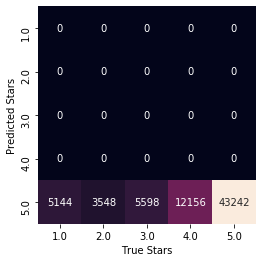

In [17]:
results_tdidf = train_model(X_train, X_test, y_train, y_test)

In [18]:
print(results_tdidf)

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      5144
         2.0       0.00      0.00      0.00      3548
         3.0       0.00      0.00      0.00      5598
         4.0       0.00      0.00      0.00     12156
         5.0       0.62      1.00      0.77     43242

    accuracy                           0.62     69688
   macro avg       0.12      0.20      0.15     69688
weighted avg       0.39      0.62      0.48     69688



# Positivo o negativo

In [19]:
# Separación entre train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_txt['review_body'], df_txt['sentiment'], test_size=0.33, random_state=42)

from sklearn.feature_extraction.text import CountVectorizer
modelo_sentiment = CountVectorizer(ngram_range = ((2,2)), stop_words=set(my_stop_words),min_df=0.01,max_df=0.98)
# Entreno con el count directamente.
X_train = modelo_sentiment.fit_transform(X_train)
# transformo sobre el test.
X_test = modelo_sentiment.transform(X_test)
# Imprimo directamente el shape de ambos.
print(X_train.shape,X_test.shape)

(233454, 20) (114985, 20)


/home/elias/.conda/envs/siisa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8757055268078445
(2, 2)


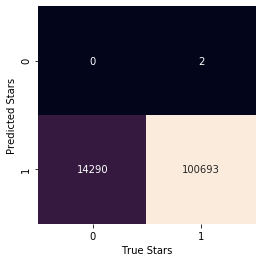

In [20]:
results_sentiment = train_model(X_train, X_test, y_train, y_test)

In [21]:
print(results_sentiment)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14290
           1       0.88      1.00      0.93    100695

    accuracy                           0.88    114985
   macro avg       0.44      0.50      0.47    114985
weighted avg       0.77      0.88      0.82    114985



### Prediccion
Entreno el modelo que voy a disponibilizar.

In [22]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
pd.Series({var: coef for var,coef in zip(modelo_sentiment.vocabulary_.keys(),lr.coef_[0])}).sort_values()


great bag          -0.546572
great price        -0.377080
plenty room         0.025917
looks like          0.443899
love bag            0.468147
highly recommend    0.492948
just right          0.826892
great quality       0.950342
bag great           0.998117
light weight        1.042947
year old            1.619241
perfect size        1.724013
high quality        1.741655
really like         1.871796
great product       1.994823
shoulder strap      2.002414
water bottle        2.056187
good quality        2.172493
looks great         2.351215
easy use            2.507680
dtype: float64

In [24]:
from numpy.random import randint
nrow = randint(0,df_txt.shape[0])
txt2predict = modelo_sentiment.transform([df_txt.loc[nrow,'review_body']])

In [25]:
lr.predict(txt2predict)

array([1])

## WordClouds 

In [26]:
textos_positivos = df_txt[df_txt.sentiment==1].review_body
textos_negativos = df_txt[df_txt.sentiment==0].review_body

### textos positivos. 

In [27]:
vectorizer = CountVectorizer(ngram_range = ((2,2)), stop_words=set(my_stop_words),min_df=0.01,max_df=0.98)
tdm = vectorizer.fit_transform(textos_positivos)
freqs_pos = {word: tdm.getcol(idx).sum() for word, idx in vectorizer.vocabulary_.items()}


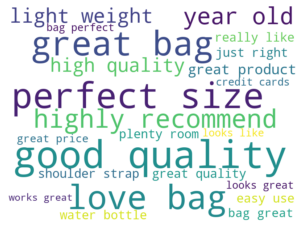

In [28]:
w = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=2000)
w.generate_from_frequencies(freqs_pos)
plt.imshow(w, interpolation='bilinear')
plt.axis("off")
plt.show()

### textos Negativos

In [29]:
vectorizer = CountVectorizer(ngram_range = ((2,2)), stop_words=set(my_stop_words),min_df=0.01,max_df=0.98)
tdm = vectorizer.fit_transform(textos_negativos)
freqs_neg = {word: tdm.getcol(idx).sum() for word, idx in vectorizer.vocabulary_.items()}


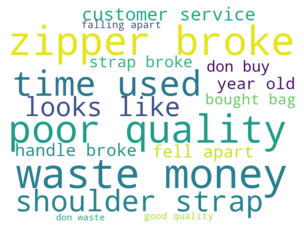

In [30]:
w = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=2000)
w.generate_from_frequencies(freqs_neg)
plt.imshow(w, interpolation='bilinear')
plt.axis("off")
plt.show()

Propuesta para maximizar: La idea es acciones que aumenten las ventas. Por lo tanto tendria que ver algo que efectivamente 
    en el clustering diferencie los grupos que tienen muchas reseñas con votos utiles de aquellas que no. Tal vez en el texto vea algo que efectivamente me permita generar buenas reseñas.